# Q-learning

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [43]:
import gym
import numpy as np

In [44]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.8.0
Default GPU Device: /device:GPU:0


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

>**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [45]:
import gym

# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [46]:
env.reset()
for _ in range(10):
    # env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

state, action, reward, done, info: [-0.01382967 -0.15667461 -0.03637745  0.30053953] 0 1.0 False {}
state, action, reward, done, info: [-0.01696316  0.03894644 -0.03036666 -0.00339054] 1 1.0 False {}
state, action, reward, done, info: [-0.01618423 -0.15572714 -0.03043447  0.27955878] 0 1.0 False {}
state, action, reward, done, info: [-0.01929877 -0.35040202 -0.02484329  0.56248952] 0 1.0 False {}
state, action, reward, done, info: [-0.02630681 -0.5451667  -0.0135935   0.84724321] 0 1.0 False {}
state, action, reward, done, info: [-0.03721015 -0.74010061  0.00335136  1.1356207 ] 0 1.0 False {}
state, action, reward, done, info: [-0.05201216 -0.93526625  0.02606378  1.42935281] 0 1.0 False {}
state, action, reward, done, info: [-0.07071748 -0.74047565  0.05465083  1.14492804] 1 1.0 False {}
state, action, reward, done, info: [-0.085527   -0.54610849  0.07754939  0.86987193] 1 1.0 False {}
state, action, reward, done, info: [-0.09644917 -0.74219486  0.09494683  1.18589416] 0 1.0 False {}


To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [47]:
# print(rewards[-20:])
# print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
# print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
# print(np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
# print(np.max(np.array(rewards)), np.min(np.array(rewards)))
# print(np.max(np.array(states)), np.min(np.array(states)))

The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [48]:
# Data of the model
def model_input(state_size):
    # Current states and actions for calculating Qs
    actions = tf.placeholder(tf.int32, [None], name='actions')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    
    # Calculated targetQs
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    
    # returning the given data to the model
    return actions, states, targetQs

In [49]:
# Generator: Generating/prediting the actions
def generator(actions, states, 
              action_size, hidden_size, 
              reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # Fusing/merge the inputs
        x_fused = tf.concat(axis=1, values=[actions, states])
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [50]:
def model_loss(actions, states, 
               targetQs, # model input data for targetQs
               action_size, hidden_size): # model init for Qs
    
    # Calculating action logits: Used to calculate Qs and targetQs
    actions_onehot = tf.one_hot(indices=actions, depth=action_size, dtype=states.dtype)
    actions_logits = generator(actions=actions_onehot, states=states,
                               hidden_size=hidden_size, action_size=action_size)
    
    # # Calculating targetQs using NEW memory using rewards
    # rewarded_actions_logits = np.multiply(actions_logits, rewards.reshape([-1, 1]))
    # Qs = np.max(rewarded_actions_logits, axis=1)
    
    # # Calculating Qs using NEW memory using actions
    Qs_onehot = tf.multiply(actions_logits[:-1], actions_onehot[1:])
    Qs = tf.reduce_max(Qs_onehot, axis=1)
    
    # Calculating the loss: logits/predictions vs labels
    loss = tf.reduce_mean(tf.square(Qs - targetQs[1:]))
    #loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs, labels=tf.nn.sigmoid(targetQs[1:])))
    
    return actions_logits, loss

In [51]:
def model_opt(loss, learning_rate):
    """
    Get optimization operations in order
    :param loss: Generator loss Tensor for action prediction
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        opt = tf.train.AdamOptimizer(learning_rate).minimize(loss, var_list=g_vars)

    return opt

In [52]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.actions, self.states, self.targetQs = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.loss = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            actions=self.actions, states=self.states, targetQs=self.targetQs) # model input data

        # Update the model: backward pass and backprop
        self.opt = model_opt(loss=self.loss, learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [53]:
from collections import deque

class Memory():    
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [54]:
print('state size:{}'.format(state.shape), 
      'action:{}'.format(action)) #(np.max(action) - np.min(action)+1)

state size:(4,) action:0


In [55]:
# Training parameters
train_episodes = 2000          # max number of episodes to learn from
max_steps = 100000000          # max steps in an episode
learning_rate = 0.001          # learning rate for adam

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4                 # number of units for the input state/observation -- simulation
hidden_size = 64               # number of units in each Q-network hidden layer -- simulation
action_size = 2                # number of units for the output actions -- simulation
batch_size = 500               # number of samples in the memory/ experience as mini-batch size

In [56]:
# Reset/init the graph/session
tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

# Init the memory
memory = Memory(max_size=batch_size)

## Populate the memory (exprience memory)

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [57]:
# Initialize the simulation
env.reset()

# Make a bunch of random actions and store the experiences
for _ in range(batch_size):
    
    # Take one random step to get the pole and cart moving
    action = env.action_space.sample()
    state, _, done, _ = env.step(action)
    reward = 1 - float(done)
    memory.buffer.append((action, state, reward))
    
    # End of the episodes which defines the goal of the episode/mission
    if done is True:
        # Start new episode
        env.reset()

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [58]:
state, reward, action

(array([ 0.23091251,  0.96085225, -0.22315945, -1.39903123]), 0.0, 0)

In [59]:
# Now train with experiences
saver = tf.train.Saver()

# Total rewards and losses list for plotting after training session/graph
rewards_list = [] # accuracy
loss_list = [] # loss

# TF session for training
with tf.Session() as sess:
    
    # Initialize/restore variables
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Explore or exploit parameter
    total_step = 0
    
    # Training episodes/epochs
    for ep in range(train_episodes):
        
        # Start new episode
        env.reset()
        total_reward = 0
        loss_batch = []

        # Training steps/batches
        for _ in range(max_steps): # start=0, step=1, stop=max_steps/done/reward
            
            # Batch from OLD memory
            batch = memory.buffer
            actions = np.array([each[0] for each in batch])
            states = np.array([each[1] for each in batch])
            #rewards = np.array([each[2] for each in batch])
            
            # Calculating the next action
            feed_dict={model.actions: actions, 
                       model.states: states}
            actions_logits = sess.run(model.actions_logits, feed_dict)
            last_action_logits = actions_logits[-1]
            
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from model
                action = np.argmax(last_action_logits)
            
            # Take new action, get new state and reward
            state, _, done, _ = env.step(action)
            reward = 1 - float(done)
            
            # New memory (time direction)
            memory.buffer.append((action, state, reward))
            
            # Cumulative rewards
            total_reward += reward

            # Batch from NEW memory
            batch = memory.buffer
            actions = np.array([each[0] for each in batch])
            states = np.array([each[1] for each in batch])
            rewards = np.array([each[2] for each in batch])

            # Calculating targetQs/nextQs using NEW memory
            feed_dict={model.actions: actions, 
                       model.states: states}
            actions_logits = sess.run(model.actions_logits, feed_dict)            
            rewarded_actions_logits = np.multiply(actions_logits, rewards.reshape([-1, 1]))
            targetQs = np.max(rewarded_actions_logits, axis=1)

            # Updating the model using NEW memory and targetQs/nextQs
            feed_dict={model.actions: actions, 
                       model.states: states, 
                       model.targetQs: targetQs} # labelQs
            loss, _ = sess.run([model.loss, model.opt], feed_dict)

            # For average loss in one episode/epoch
            loss_batch.append(loss)

            # At the end of steps/batches loop
            if done is True:
                break
                
        # At the end of each episode/epoch
        print('-------------------------------------------------------------------------------')
        print('Episode: {}'.format(ep),
              'Total reward: {}'.format(total_reward),
              'Average loss: {:.4f}'.format(np.mean(loss_batch)),
              'Explore P: {:.4f}'.format(explore_p))
        print('-------------------------------------------------------------------------------')

        # At the end of each episode/epoch
        # total rewards and losses for plotting
        rewards_list.append((ep, total_reward))
        loss_list.append((ep, np.mean(loss_batch)))
        
    # At the end of all training episodes/epochs
    # Save the trained model
    saver.save(sess, 'checkpoints/model.ckpt')

-------------------------------------------------------------------------------
Episode: 0 Total reward: 29.0 Average loss: 0.0802 Explore P: 0.9970
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1 Total reward: 11.0 Average loss: 0.0935 Explore P: 0.9959
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2 Total reward: 23.0 Average loss: 0.0975 Explore P: 0.9935
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3 Total reward: 11.0 Average loss: 0.0987 Explore P: 0.9923
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Epis

-------------------------------------------------------------------------------
Episode: 37 Total reward: 19.0 Average loss: 0.0668 Explore P: 0.9214
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 38 Total reward: 9.0 Average loss: 0.0648 Explore P: 0.9205
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 39 Total reward: 11.0 Average loss: 0.0647 Explore P: 0.9194
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 40 Total reward: 23.0 Average loss: 0.0659 Explore P: 0.9172
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
E

-------------------------------------------------------------------------------
Episode: 73 Total reward: 14.0 Average loss: 0.0612 Explore P: 0.8613
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 74 Total reward: 23.0 Average loss: 0.0627 Explore P: 0.8593
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 75 Total reward: 31.0 Average loss: 0.0645 Explore P: 0.8566
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 76 Total reward: 40.0 Average loss: 0.0673 Explore P: 0.8531
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------


-------------------------------------------------------------------------------
Episode: 109 Total reward: 39.0 Average loss: 0.0566 Explore P: 0.7994
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 110 Total reward: 28.0 Average loss: 0.0597 Explore P: 0.7971
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 111 Total reward: 28.0 Average loss: 0.0613 Explore P: 0.7949
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 112 Total reward: 16.0 Average loss: 0.0608 Explore P: 0.7935
-------------------------------------------------------------------------------
----------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 145 Total reward: 13.0 Average loss: 0.0573 Explore P: 0.7429
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 146 Total reward: 8.0 Average loss: 0.0571 Explore P: 0.7422
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 147 Total reward: 20.0 Average loss: 0.0567 Explore P: 0.7407
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 148 Total reward: 11.0 Average loss: 0.0558 Explore P: 0.7398
-------------------------------------------------------------------------------
-----------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 181 Total reward: 14.0 Average loss: 0.0464 Explore P: 0.6998
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 182 Total reward: 11.0 Average loss: 0.0479 Explore P: 0.6990
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 183 Total reward: 12.0 Average loss: 0.0525 Explore P: 0.6981
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 184 Total reward: 12.0 Average loss: 0.0545 Explore P: 0.6972
-------------------------------------------------------------------------------
----------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 218 Total reward: 13.0 Average loss: 0.0388 Explore P: 0.6601
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 219 Total reward: 14.0 Average loss: 0.0412 Explore P: 0.6591
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 220 Total reward: 10.0 Average loss: 0.0411 Explore P: 0.6584
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 221 Total reward: 10.0 Average loss: 0.0409 Explore P: 0.6577
-------------------------------------------------------------------------------
----------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 254 Total reward: 20.0 Average loss: 0.0307 Explore P: 0.6241
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 255 Total reward: 15.0 Average loss: 0.0307 Explore P: 0.6231
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 256 Total reward: 9.0 Average loss: 0.0304 Explore P: 0.6225
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 257 Total reward: 11.0 Average loss: 0.0304 Explore P: 0.6217
-------------------------------------------------------------------------------
-----------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 291 Total reward: 13.0 Average loss: 0.0368 Explore P: 0.5916
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 292 Total reward: 12.0 Average loss: 0.0337 Explore P: 0.5909
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 293 Total reward: 13.0 Average loss: 0.0325 Explore P: 0.5900
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 294 Total reward: 14.0 Average loss: 0.0328 Explore P: 0.5892
-------------------------------------------------------------------------------
----------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 327 Total reward: 13.0 Average loss: 0.0291 Explore P: 0.5613
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 328 Total reward: 10.0 Average loss: 0.0287 Explore P: 0.5607
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 329 Total reward: 11.0 Average loss: 0.0270 Explore P: 0.5600
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 330 Total reward: 18.0 Average loss: 0.0292 Explore P: 0.5589
-------------------------------------------------------------------------------
----------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 366 Total reward: 11.0 Average loss: 0.0263 Explore P: 0.5338
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 367 Total reward: 14.0 Average loss: 0.0267 Explore P: 0.5331
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 368 Total reward: 9.0 Average loss: 0.0246 Explore P: 0.5325
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 369 Total reward: 12.0 Average loss: 0.0218 Explore P: 0.5319
-------------------------------------------------------------------------------
-----------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 402 Total reward: 12.0 Average loss: 0.0488 Explore P: 0.5077
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 403 Total reward: 23.0 Average loss: 0.0517 Explore P: 0.5065
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 404 Total reward: 18.0 Average loss: 0.0521 Explore P: 0.5055
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 405 Total reward: 19.0 Average loss: 0.0522 Explore P: 0.5045
-------------------------------------------------------------------------------
----------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 439 Total reward: 12.0 Average loss: 0.0275 Explore P: 0.4834
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 440 Total reward: 14.0 Average loss: 0.0250 Explore P: 0.4827
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 441 Total reward: 21.0 Average loss: 0.0251 Explore P: 0.4817
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 442 Total reward: 10.0 Average loss: 0.0248 Explore P: 0.4812
-------------------------------------------------------------------------------
----------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 475 Total reward: 14.0 Average loss: 0.0248 Explore P: 0.4612
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 476 Total reward: 10.0 Average loss: 0.0264 Explore P: 0.4607
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 477 Total reward: 12.0 Average loss: 0.0287 Explore P: 0.4601
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 478 Total reward: 13.0 Average loss: 0.0285 Explore P: 0.4595
-------------------------------------------------------------------------------
----------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 511 Total reward: 14.0 Average loss: 0.0433 Explore P: 0.4415
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 512 Total reward: 14.0 Average loss: 0.0430 Explore P: 0.4408
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 513 Total reward: 9.0 Average loss: 0.0428 Explore P: 0.4404
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 514 Total reward: 12.0 Average loss: 0.0428 Explore P: 0.4398
-------------------------------------------------------------------------------
-----------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 547 Total reward: 12.0 Average loss: 0.0254 Explore P: 0.4228
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 548 Total reward: 10.0 Average loss: 0.0252 Explore P: 0.4224
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 549 Total reward: 8.0 Average loss: 0.0251 Explore P: 0.4220
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 550 Total reward: 10.0 Average loss: 0.0250 Explore P: 0.4215
-------------------------------------------------------------------------------
-----------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 584 Total reward: 14.0 Average loss: 0.0215 Explore P: 0.4037
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 585 Total reward: 10.0 Average loss: 0.0216 Explore P: 0.4032
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 586 Total reward: 15.0 Average loss: 0.0219 Explore P: 0.4026
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 587 Total reward: 14.0 Average loss: 0.0223 Explore P: 0.4020
-------------------------------------------------------------------------------
----------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 622 Total reward: 9.0 Average loss: 0.0247 Explore P: 0.3862
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 623 Total reward: 11.0 Average loss: 0.0249 Explore P: 0.3857
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 624 Total reward: 10.0 Average loss: 0.0248 Explore P: 0.3853
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 625 Total reward: 16.0 Average loss: 0.0247 Explore P: 0.3847
-------------------------------------------------------------------------------
-----------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 659 Total reward: 13.0 Average loss: 0.0187 Explore P: 0.3707
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 660 Total reward: 7.0 Average loss: 0.0186 Explore P: 0.3704
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 661 Total reward: 13.0 Average loss: 0.0184 Explore P: 0.3699
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 662 Total reward: 12.0 Average loss: 0.0183 Explore P: 0.3694
-------------------------------------------------------------------------------
-----------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 697 Total reward: 12.0 Average loss: 0.0201 Explore P: 0.3549
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 698 Total reward: 8.0 Average loss: 0.0197 Explore P: 0.3546
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 699 Total reward: 8.0 Average loss: 0.0197 Explore P: 0.3543
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 700 Total reward: 9.0 Average loss: 0.0197 Explore P: 0.3540
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 733 Total reward: 11.0 Average loss: 0.0218 Explore P: 0.3405
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 734 Total reward: 12.0 Average loss: 0.0236 Explore P: 0.3401
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 735 Total reward: 8.0 Average loss: 0.0234 Explore P: 0.3398
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 736 Total reward: 11.0 Average loss: 0.0233 Explore P: 0.3394
-------------------------------------------------------------------------------
-----------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 769 Total reward: 16.0 Average loss: 0.0263 Explore P: 0.3260
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 770 Total reward: 11.0 Average loss: 0.0261 Explore P: 0.3256
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 771 Total reward: 13.0 Average loss: 0.0260 Explore P: 0.3252
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 772 Total reward: 9.0 Average loss: 0.0260 Explore P: 0.3249
-------------------------------------------------------------------------------
-----------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 805 Total reward: 8.0 Average loss: 0.0197 Explore P: 0.3133
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 806 Total reward: 11.0 Average loss: 0.0194 Explore P: 0.3129
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 807 Total reward: 16.0 Average loss: 0.0197 Explore P: 0.3124
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 808 Total reward: 10.0 Average loss: 0.0198 Explore P: 0.3121
-------------------------------------------------------------------------------
-----------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 844 Total reward: 9.0 Average loss: 0.0215 Explore P: 0.3005
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 845 Total reward: 7.0 Average loss: 0.0215 Explore P: 0.3002
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 846 Total reward: 11.0 Average loss: 0.0216 Explore P: 0.2999
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 847 Total reward: 13.0 Average loss: 0.0216 Explore P: 0.2995
-------------------------------------------------------------------------------
------------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 880 Total reward: 10.0 Average loss: 0.0196 Explore P: 0.2887
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 881 Total reward: 10.0 Average loss: 0.0197 Explore P: 0.2884
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 882 Total reward: 8.0 Average loss: 0.0197 Explore P: 0.2882
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 883 Total reward: 9.0 Average loss: 0.0197 Explore P: 0.2879
-------------------------------------------------------------------------------
------------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 917 Total reward: 9.0 Average loss: 0.0183 Explore P: 0.2778
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 918 Total reward: 7.0 Average loss: 0.0183 Explore P: 0.2776
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 919 Total reward: 8.0 Average loss: 0.0183 Explore P: 0.2774
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 920 Total reward: 12.0 Average loss: 0.0182 Explore P: 0.2770
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 954 Total reward: 10.0 Average loss: 0.0176 Explore P: 0.2675
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 955 Total reward: 10.0 Average loss: 0.0177 Explore P: 0.2673
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 956 Total reward: 10.0 Average loss: 0.0177 Explore P: 0.2670
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 957 Total reward: 10.0 Average loss: 0.0177 Explore P: 0.2667
-------------------------------------------------------------------------------
----------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 993 Total reward: 9.0 Average loss: 0.0180 Explore P: 0.2565
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 994 Total reward: 8.0 Average loss: 0.0179 Explore P: 0.2563
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 995 Total reward: 10.0 Average loss: 0.0179 Explore P: 0.2560
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 996 Total reward: 9.0 Average loss: 0.0178 Explore P: 0.2557
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1032 Total reward: 10.0 Average loss: 0.0183 Explore P: 0.2458
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1033 Total reward: 9.0 Average loss: 0.0181 Explore P: 0.2455
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1034 Total reward: 9.0 Average loss: 0.0181 Explore P: 0.2453
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1035 Total reward: 11.0 Average loss: 0.0181 Explore P: 0.2450
-------------------------------------------------------------------------------
--------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1069 Total reward: 8.0 Average loss: 0.0178 Explore P: 0.2367
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1070 Total reward: 8.0 Average loss: 0.0178 Explore P: 0.2365
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1071 Total reward: 9.0 Average loss: 0.0177 Explore P: 0.2363
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1072 Total reward: 8.0 Average loss: 0.0177 Explore P: 0.2361
-------------------------------------------------------------------------------
----------------------------------------------------------------------------

Episode: 1105 Total reward: 8.0 Average loss: 0.0183 Explore P: 0.2281
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1106 Total reward: 9.0 Average loss: 0.0182 Explore P: 0.2279
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1107 Total reward: 8.0 Average loss: 0.0181 Explore P: 0.2277
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1108 Total reward: 11.0 Average loss: 0.0181 Explore P: 0.2274
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1109 Total reward: 10.0 Average loss: 0.0182 Explore P: 0.2272
---

-------------------------------------------------------------------------------
Episode: 1143 Total reward: 9.0 Average loss: 0.0179 Explore P: 0.2196
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1144 Total reward: 15.0 Average loss: 0.0185 Explore P: 0.2193
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1145 Total reward: 11.0 Average loss: 0.0184 Explore P: 0.2190
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1146 Total reward: 9.0 Average loss: 0.0181 Explore P: 0.2188
-------------------------------------------------------------------------------
--------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1182 Total reward: 9.0 Average loss: 0.0169 Explore P: 0.2113
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1183 Total reward: 9.0 Average loss: 0.0169 Explore P: 0.2111
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1184 Total reward: 11.0 Average loss: 0.0172 Explore P: 0.2108
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1185 Total reward: 9.0 Average loss: 0.0173 Explore P: 0.2106
-------------------------------------------------------------------------------
---------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1220 Total reward: 10.0 Average loss: 0.0179 Explore P: 0.2033
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1221 Total reward: 10.0 Average loss: 0.0179 Explore P: 0.2031
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1222 Total reward: 10.0 Average loss: 0.0179 Explore P: 0.2028
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1223 Total reward: 11.0 Average loss: 0.0178 Explore P: 0.2026
-------------------------------------------------------------------------------
------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1258 Total reward: 8.0 Average loss: 0.0175 Explore P: 0.1956
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1259 Total reward: 9.0 Average loss: 0.0174 Explore P: 0.1955
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1260 Total reward: 11.0 Average loss: 0.0175 Explore P: 0.1952
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1261 Total reward: 9.0 Average loss: 0.0175 Explore P: 0.1950
-------------------------------------------------------------------------------
---------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1295 Total reward: 13.0 Average loss: 0.0182 Explore P: 0.1885
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1296 Total reward: 8.0 Average loss: 0.0182 Explore P: 0.1884
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1297 Total reward: 9.0 Average loss: 0.0183 Explore P: 0.1882
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1298 Total reward: 11.0 Average loss: 0.0182 Explore P: 0.1880
-------------------------------------------------------------------------------
--------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1331 Total reward: 8.0 Average loss: 0.0179 Explore P: 0.1818
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1332 Total reward: 10.0 Average loss: 0.0181 Explore P: 0.1816
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1333 Total reward: 13.0 Average loss: 0.0185 Explore P: 0.1813
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1334 Total reward: 11.0 Average loss: 0.0186 Explore P: 0.1811
-------------------------------------------------------------------------------
-------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1370 Total reward: 10.0 Average loss: 0.0224 Explore P: 0.1748
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1371 Total reward: 9.0 Average loss: 0.0224 Explore P: 0.1746
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1372 Total reward: 10.0 Average loss: 0.0225 Explore P: 0.1745
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1373 Total reward: 10.0 Average loss: 0.0225 Explore P: 0.1743
-------------------------------------------------------------------------------
-------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1408 Total reward: 8.0 Average loss: 0.0186 Explore P: 0.1686
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1409 Total reward: 10.0 Average loss: 0.0183 Explore P: 0.1684
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1410 Total reward: 8.0 Average loss: 0.0180 Explore P: 0.1683
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1411 Total reward: 9.0 Average loss: 0.0180 Explore P: 0.1681
-------------------------------------------------------------------------------
---------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1445 Total reward: 7.0 Average loss: 0.0177 Explore P: 0.1628
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1446 Total reward: 9.0 Average loss: 0.0175 Explore P: 0.1626
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1447 Total reward: 9.0 Average loss: 0.0174 Explore P: 0.1625
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1448 Total reward: 11.0 Average loss: 0.0171 Explore P: 0.1623
-------------------------------------------------------------------------------
---------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1482 Total reward: 8.0 Average loss: 0.0176 Explore P: 0.1572
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1483 Total reward: 7.0 Average loss: 0.0175 Explore P: 0.1571
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1484 Total reward: 9.0 Average loss: 0.0175 Explore P: 0.1569
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1485 Total reward: 11.0 Average loss: 0.0175 Explore P: 0.1568
-------------------------------------------------------------------------------
---------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1518 Total reward: 11.0 Average loss: 0.0170 Explore P: 0.1520
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1519 Total reward: 8.0 Average loss: 0.0169 Explore P: 0.1518
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1520 Total reward: 16.0 Average loss: 0.0176 Explore P: 0.1516
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1521 Total reward: 10.0 Average loss: 0.0178 Explore P: 0.1514
-------------------------------------------------------------------------------
-------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1556 Total reward: 8.0 Average loss: 0.0200 Explore P: 0.1463
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1557 Total reward: 9.0 Average loss: 0.0200 Explore P: 0.1461
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1558 Total reward: 10.0 Average loss: 0.0196 Explore P: 0.1460
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1559 Total reward: 10.0 Average loss: 0.0195 Explore P: 0.1458
-------------------------------------------------------------------------------
--------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1593 Total reward: 9.0 Average loss: 0.0173 Explore P: 0.1413
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1594 Total reward: 9.0 Average loss: 0.0173 Explore P: 0.1412
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1595 Total reward: 9.0 Average loss: 0.0173 Explore P: 0.1411
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1596 Total reward: 10.0 Average loss: 0.0172 Explore P: 0.1409
-------------------------------------------------------------------------------
---------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1629 Total reward: 8.0 Average loss: 0.0164 Explore P: 0.1366
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1630 Total reward: 9.0 Average loss: 0.0164 Explore P: 0.1365
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1631 Total reward: 9.0 Average loss: 0.0164 Explore P: 0.1364
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1632 Total reward: 9.0 Average loss: 0.0164 Explore P: 0.1363
-------------------------------------------------------------------------------
----------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1666 Total reward: 9.0 Average loss: 0.0166 Explore P: 0.1319
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1667 Total reward: 8.0 Average loss: 0.0167 Explore P: 0.1318
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1668 Total reward: 8.0 Average loss: 0.0167 Explore P: 0.1317
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1669 Total reward: 10.0 Average loss: 0.0167 Explore P: 0.1315
-------------------------------------------------------------------------------
---------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1704 Total reward: 7.0 Average loss: 0.0161 Explore P: 0.1274
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1705 Total reward: 11.0 Average loss: 0.0161 Explore P: 0.1272
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1706 Total reward: 9.0 Average loss: 0.0161 Explore P: 0.1271
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1707 Total reward: 8.0 Average loss: 0.0161 Explore P: 0.1270
-------------------------------------------------------------------------------
---------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1742 Total reward: 8.0 Average loss: 0.0173 Explore P: 0.1228
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1743 Total reward: 8.0 Average loss: 0.0173 Explore P: 0.1227
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1744 Total reward: 9.0 Average loss: 0.0173 Explore P: 0.1226
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1745 Total reward: 9.0 Average loss: 0.0172 Explore P: 0.1224
-------------------------------------------------------------------------------
----------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1778 Total reward: 8.0 Average loss: 0.0260 Explore P: 0.1188
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1779 Total reward: 9.0 Average loss: 0.0259 Explore P: 0.1187
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1780 Total reward: 9.0 Average loss: 0.0259 Explore P: 0.1186
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1781 Total reward: 7.0 Average loss: 0.0260 Explore P: 0.1185
-------------------------------------------------------------------------------
----------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1815 Total reward: 9.0 Average loss: 0.0162 Explore P: 0.1149
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1816 Total reward: 8.0 Average loss: 0.0162 Explore P: 0.1148
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1817 Total reward: 9.0 Average loss: 0.0162 Explore P: 0.1147
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1818 Total reward: 8.0 Average loss: 0.0162 Explore P: 0.1146
-------------------------------------------------------------------------------
----------------------------------------------------------------------------

Episode: 1852 Total reward: 9.0 Average loss: 0.0164 Explore P: 0.1111
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1853 Total reward: 10.0 Average loss: 0.0163 Explore P: 0.1110
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1854 Total reward: 10.0 Average loss: 0.0163 Explore P: 0.1109
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1855 Total reward: 9.0 Average loss: 0.0162 Explore P: 0.1108
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1856 Total reward: 8.0 Average loss: 0.0162 Explore P: 0.1107
---

-------------------------------------------------------------------------------
Episode: 1890 Total reward: 11.0 Average loss: 0.0166 Explore P: 0.1074
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1891 Total reward: 9.0 Average loss: 0.0167 Explore P: 0.1073
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1892 Total reward: 9.0 Average loss: 0.0165 Explore P: 0.1072
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1893 Total reward: 10.0 Average loss: 0.0164 Explore P: 0.1071
-------------------------------------------------------------------------------
--------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1929 Total reward: 10.0 Average loss: 0.0168 Explore P: 0.1037
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1930 Total reward: 10.0 Average loss: 0.0165 Explore P: 0.1036
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1931 Total reward: 9.0 Average loss: 0.0165 Explore P: 0.1035
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1932 Total reward: 10.0 Average loss: 0.0165 Explore P: 0.1034
-------------------------------------------------------------------------------
-------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1966 Total reward: 9.0 Average loss: 0.0166 Explore P: 0.1003
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1967 Total reward: 7.0 Average loss: 0.0166 Explore P: 0.1003
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1968 Total reward: 9.0 Average loss: 0.0166 Explore P: 0.1002
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1969 Total reward: 9.0 Average loss: 0.0166 Explore P: 0.1001
-------------------------------------------------------------------------------
----------------------------------------------------------------------------

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [60]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

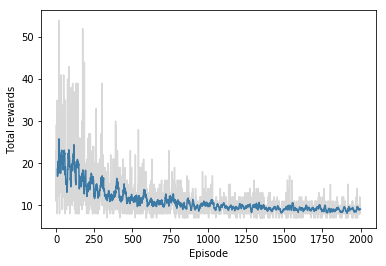

In [61]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Average losses')

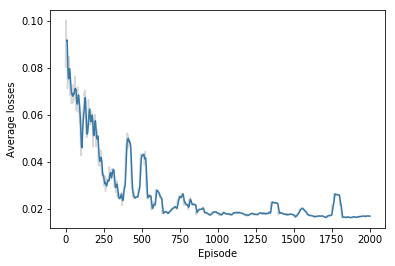

In [62]:
eps, arr = np.array(loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Average losses')

## Testing

Let's checkout how our trained agent plays the game.

In [42]:
import gym

# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

test_episodes = 1
test_max_steps = 20000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

with tf.Session() as sess:

    # Initialize/restore/load the trained model 
    #sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # iterations
    for ep in range(test_episodes):

        # Start new episode/epoch
        env.reset()

        # Take one random step to get the pole and cart moving
        action = env.action_space.sample()
        state, _, done, _ = env.step(action)
        #reward = 1 - float(done)
        
        # number of env/rob steps
        for _ in range(test_max_steps):
            
            # Rendering the env graphics
            env.render()
            
            # Get action from DQAN
            feed_dict={model.actions: np.array([action]), 
                       model.states: state.reshape((1, *state.shape))}
            actions_logits = sess.run(model.actions_logits, feed_dict)
            
            # Take action, get new state and reward
            action = np.argmax(actions_logits)
            state, _, done, _ = env.step(action)
            #reward = 1 - float(done)
            
            # The task is done or not;
            if done:
                break
                
# Closing the env
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.